# Analyzing the simulation result

Folder in F:\METS_R\exp2

In [131]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpdikj
from tqdm import trange
from time import sleep

%matplotlib inline

Settings and functions

In [132]:
matplotlib.rcParams.update({
    'figure.dpi': 300,
    'figure.titlesize': 15,
    'axes.titlesize': 15,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'legend.title_fontsize': 13
})

In [133]:
def read_output_veh(data):
    temp = df['vehOnRoad']
    veh_on_road = sum(temp[int((len(temp)+1)/2):])/24
    other_info = df.iloc[-1] - df.iloc[int((len(temp)-1)/2)]
    charge_times = other_info.loc['chargingTrip'].tolist()/24
    
    taxi_data = other_info.loc[['generatedTaxiPass','taxiServedPass','taxiLeavedPass']].tolist()
    bus_data = other_info.loc[['generatedBusPass','busServedPass','busLeavedPass']].tolist()

    taxi_data = np.array(taxi_data)/24
    bus_data = np.array(bus_data)/24
    
    return veh_on_road,charge_times,taxi_data,bus_data

In [134]:
def plot_radar(values, feature, color, label, ax):
    N = len(values)
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)+np.pi/6
    values=np.concatenate((values,[values[0]]))
    angles2=np.concatenate((angles,[angles[0]]))
    ax.plot(angles2, values, 'o-', linewidth=2, label = label, color = color)
    ax.set_thetagrids(angles * 180/np.pi, feature)
    ax.set_ylim(0,1)

In [135]:
def plot_radar_n(values,true_values,feature,colors, labels, ax):
    colors = colors
    nums = values.shape[1]
    N = len(values[:,0])
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)
    angles2=np.concatenate((angles,[angles[0]]))
    
    for num in range(nums):
        
        plot_value=np.concatenate((values[:,num],[values[:,num][0]]))
        true_value = true_values[:,num]
        plot_radar(values[:,num], feature, colors[num], labels[num], ax)
        n = 0
#         print(true_value)
        for a, b in zip(angles2[:-1], plot_value[:-1]):
            text_n = true_value[n]
            ax.text(a, b, '%.1f' % text_n, ha='center', va='center', fontsize=8, color=colors[num])
            n+=1
    
    plt.legend(bbox_to_anchor=(1.05, 0.30))
    ax.grid(True)

In [136]:
from sklearn.preprocessing import MinMaxScaler

def fun(data):
    scaler = (data-np.min(data,axis = 0))/ ((np.max(data,axis = 0)+1e-4)-np.min(data,axis = 0)) * 0.4 + 0.5
    return scaler

The names of the files are bad, how to improve it?

Name by distinguishable settings.

# Parameter tuning

 'Occupancy rate', "Occupied mileage",
               'Idling mileage', 'Taxi served passengers', 'Bus served passengers', 
               'Taxi left passengers', 'Bus left passengers',
               'Taxi waiting time (min)', 'Bus waiting time (min)',
               'Taxi energy consumption (kwh)', 'Bus energy consumption (kwh)',
              'Taxi charging duration (h)','Taxi charging times',\
               'Taxi waiting in charging queue (min)',\
               'Bus charging duration (h)','Bus charging times',\
              'Bus waiting in charging queue (min)'

In [138]:
def process_data(curr_folder, ev_num, start_hour = 3, end_hour = 27):
    # Served passengers (%)
    # Share of taxi served demand (%)
    # Average passenger waiting time for E-taxis
    # Average passenger waiting time for E-buses
    # Energy consumption per passenger mile
    # Average daily idle time per E-taxi
    filenames = os.listdir(curr_folder)
    for file in filenames:
        if "ZoneLog" in file:
            df_zone = pd.read_csv(curr_folder+file, on_bad_lines ='warn')
        elif "NetworkLog" in file:
            df_network = pd.read_csv(curr_folder+file, on_bad_lines ='warn')
        elif "EVLog" in file:
            df_ev = pd.read_csv(curr_folder+file, on_bad_lines ='warn')
        elif "BusLog" in file:
            df_bus = pd.read_csv(curr_folder+file, on_bad_lines ='warn')
        elif "LinkLog" in file:
            pass #df_link  = pd.read_csv(curr_folder+file, on_bad_lines ='warn')
            
    last_time = 12000 * end_hour
    first_time = 12000 * start_hour
    # df_ev = df_ev[df_ev['distance']>0]
    df_bus = df_bus[df_bus['routeID']!=-1]
    
    taxi_served_pass = (df_network[(df_network['tick']==last_time)]['taxiPickupPass'].values[0] -
                        df_network[(df_network['tick']==first_time)]['taxiPickupPass'].values[0] )
    bus_served_pass = (df_network[(df_network['tick']==last_time)]['busPickupPass'].values[0]  - 
                       df_network[(df_network['tick']==first_time)]['busPickupPass'].values[0] )
    combined_served_pass = (df_network[(df_network['tick']==last_time)]['combinePickupPart1'].values[0]  - 
                       df_network[(df_network['tick']==first_time)]['combinePickupPart1'].values[0] )
    taxi_wait_pass = (df_network[(df_network['tick']==last_time)]['numWaitingTaxiPass'].values[0] -
                        df_network[(df_network['tick']==first_time)]['numWaitingTaxiPass'].values[0] )
    bus_wait_pass = (df_network[(df_network['tick']==last_time)]['numWaitingBusPass'].values[0] -
                        df_network[(df_network['tick']==first_time)]['numWaitingBusPass'].values[0] )
    taxi_generated_pass = (df_network[(df_network['tick']==last_time)]['generatedTaxiPass'].values[0] -
                        df_network[(df_network['tick']==first_time)]['generatedTaxiPass'].values[0] )
    bus_generated_pass = (df_network[(df_network['tick']==last_time)]['generatedBusPass'].values[0]  - 
                       df_network[(df_network['tick']==first_time)]['generatedBusPass'].values[0] )
    combined_generated_pass = (df_network[(df_network['tick']==last_time)]['generatedCombinedPass'].values[0]  - 
                       df_network[(df_network['tick']==first_time)]['generatedCombinedPass'].values[0] )
    
    # Note we divided by served pass, which will overestimate the waiting time a little
    taxi_wait_time = (np.sum(df_zone[(df_zone['tick']==last_time)]['taxiServedPassWaitingTime'])-np.sum(df_zone[(df_zone['tick']==first_time)]['taxiServedPassWaitingTime']))/(taxi_served_pass)/12000
    if(bus_generated_pass>0):
        bus_wait_time = (np.sum(df_zone[(df_zone['tick']==last_time)]['busServedPassWaitingTime'])-np.sum(df_zone[(df_zone['tick']==first_time)]['busServedPassWaitingTime']))/(bus_served_pass)/12000
    else:
        bus_wait_time = 0
    
    taxi_ener_cons = np.sum(np.sum(df_ev[(df_ev['departureTime']<=last_time)&(df_ev['departureTime']>=first_time)]['cost']))
    bus_ener_cons = np.sum(np.sum(df_bus[(df_bus['departureTime']<=last_time)&(df_bus['departureTime']>=first_time)]['cost']))
    
    total_mileage = np.sum(np.sum(df_ev[(df_ev['departureTime']<=last_time)&(df_ev['departureTime']>=first_time)]['distance'])/1609.1)
    occu_mileage = np.sum(np.sum(df_ev[(df_ev['tripType']==1)&(df_ev['departureTime']<=last_time)&(df_ev['departureTime']>=first_time)]['distance'])/1609.1)
    pickup_mileage = np.sum(np.sum(df_ev[(df_ev['tripType']==6)&(df_ev['departureTime']<=last_time)&(df_ev['departureTime']>=first_time)]['distance'])/1609.1)
    charging_mileage = np.sum(np.sum(df_ev[(df_ev['tripType']==4)&(df_ev['departureTime']<=last_time)&(df_ev['departureTime']>=first_time)]['distance'])/1609.1)
    
    idle_mileage_rate = 1 - occu_mileage/total_mileage
                          
    return (taxi_served_pass+bus_served_pass+combined_served_pass)/(taxi_generated_pass+bus_generated_pass+\
                                                                    combined_generated_pass-taxi_wait_pass-bus_wait_pass),\
           (taxi_served_pass+combined_served_pass)/(taxi_served_pass+bus_served_pass+combined_served_pass),\
           taxi_wait_time, bus_wait_time, taxi_ener_cons/(occu_mileage), \
           idle_mileage_rate,\
           (taxi_served_pass+combined_served_pass)/(combined_generated_pass+taxi_generated_pass-taxi_wait_pass)  if taxi_generated_pass>0 or combined_generated_pass>0 else 0,\
           (bus_served_pass+combined_served_pass)/(bus_generated_pass+combined_generated_pass-bus_wait_pass) if bus_generated_pass>0 or combined_generated_pass>0 else 0,\
           taxi_ener_cons/(taxi_served_pass+combined_served_pass/2) if taxi_generated_pass>0 or combined_generated_pass>0 else 0,\
           bus_ener_cons/(bus_served_pass+combined_served_pass/2) if bus_generated_pass >0 or combined_generated_pass>0 else 0,\
(taxi_ener_cons + bus_ener_cons)/(taxi_served_pass + bus_served_pass+combined_served_pass),\
total_mileage, occu_mileage, pickup_mileage, charging_mileage

In [144]:
input_dir = "D:/OngoingResearch/2023_METSR_SIM/METS_R_Paper/data_analytics/exp1/"

In [140]:

p,q = 4,5
run_time = np.zeros((p,q))

for a in range(p):
    for b in range(q):
        i=4
        j=0
        data_dir = ''
        if(a == 3):
            data_dir += input_dir + 'scenario_'+str(a)+'_case_'+str(2*b+11)+'_seed_42_eco_false_bus_false_share_false_demand_5_taxi_' +str((i+4)*500) + "_bus_" + str(j*20) + '_full'
        else:
            data_dir += input_dir + 'scenario_'+str(a)+'_case_'+str(2*b+1)+'_seed_42_eco_false_bus_false_share_false_demand_5_taxi_'+str((i+4)*500) + "_bus_" + str(j*20) + '_full'
        data_dir += '/agg_output/'
        data_dir += str((i+4)*500)+"_" + str(j*20) + "/"
        veh_num = (i+4)*500
        filenames = os.listdir(data_dir)
        for file in filenames:
            if "ZoneLog" in file:
                pass #df_zone = pd.read_csv(curr_folder+file, on_bad_lines ='warn')
            elif "NetworkLog" in file:
                df_network = pd.read_csv(data_dir+file, on_bad_lines ='warn')
        run_time[a,b] = (df_network['timeStamp'].values[-1] - df_network['timeStamp'].values[0])//1000/60

In [141]:
np.mean(run_time)

47.9225

In [142]:
input_dir = "D:/OngoingResearch/2023_METSR_SIM/METS_R_Paper/data_analytics/exp2/"

In [143]:
m, n = 5, 6
p, q = 4, 5

served_pass = np.zeros((p,q,m,n))
taxi_served_pass = np.zeros((p,q,m,n))
bus_served_pass = np.zeros((p,q,m,n))
taxi_demand_share = np.zeros((p,q,m,n))
avg_pass_waiting_time = np.zeros((p,q,m,n))
avg_bus_waiting_time = np.zeros((p,q,m,n))
energy_consumption = np.zeros((p,q,m,n))
energy_consumption_taxi = np.zeros((p,q,m,n))
energy_consumption_bus = np.zeros((p,q,m,n))
energy_consumption_pass = np.zeros((p,q,m,n))
daily_idle_time = np.zeros((p,q,m,n))
unique_taxi_num = np.zeros((p,q,m,n))
unique_bus_num = np.zeros((p,q,m,n))

total_mileage = np.zeros((p,q,m,n))
occu_mileage = np.zeros((p,q,m,n))
pickup_mileage = np.zeros((p,q,m,n))
charging_mileage = np.zeros((p,q,m,n))



for a in range(p):
    for b in range(q):
        for i in range(m):
            for j in range(n):
                data_dir = ''
                if(a == 3):
                    data_dir += input_dir + 'scenario_'+str(a)+'_case_'+str(2*b+11)+'_seed_42_eco_false_bus_false_share_true_demand_100_taxi_' +str((i+4)*500) + "_bus_" + str(j*20) + '_pass'
                else:
                    data_dir += input_dir + 'scenario_'+str(a)+'_case_'+str(2*b+1)+'_seed_42_eco_false_bus_false_share_true_demand_100_taxi_'+str((i+4)*500) + "_bus_" + str(j*20) + '_pass'
                data_dir += '/agg_output/'
                data_dir += str((i+4)*500)+"_" + str(j*20) + "/"
                veh_num = (i+4)*500
                res = process_data(data_dir, veh_num)
                # print(str(i) + "," + str(j))
                served_pass[a,b,i,j] = res[0]
                taxi_demand_share[a,b,i,j] = res[1]
                avg_pass_waiting_time[a,b,i,j] = res[2]
                avg_bus_waiting_time[a,b,i,j] = res[3]
                energy_consumption[a,b,i,j] = res[4]
                daily_idle_time[a,b,i,j] = res[5]
                taxi_served_pass[a,b,i,j] = res[6]
                bus_served_pass[a,b,i,j] = res[7]
                energy_consumption_taxi[a,b,i,j] = res[8]
                energy_consumption_bus[a,b,i,j] = res[9]
                energy_consumption_pass[a,b,i,j] = res[10]
                total_mileage[a,b,i,j] = res[11]
                occu_mileage[a,b,i,j] = res[12]
                pickup_mileage[a,b,i,j] = res[13]
                charging_mileage[a,b,i,j] = res[14]

Skipping line 2640: expected 11 fields, saw 12

Skipping line 239625: expected 10 fields, saw 19

Skipping line 422: expected 20 fields, saw 38

Skipping line 106843: expected 24 fields, saw 33

Skipping line 458: expected 20 fields, saw 22

Skipping line 111744: expected 24 fields, saw 32

Skipping line 1107: expected 11 fields, saw 19

Skipping line 265848: expected 10 fields, saw 15
Skipping line 265958: expected 10 fields, saw 17

Skipping line 424: expected 20 fields, saw 37

Skipping line 104025: expected 24 fields, saw 38

Skipping line 320936: expected 10 fields, saw 11

Skipping line 458: expected 20 fields, saw 37

Skipping line 112788: expected 24 fields, saw 46

Skipping line 4712: expected 11 fields, saw 19

Skipping line 186294: expected 10 fields, saw 13

Skipping line 419: expected 20 fields, saw 38

Skipping line 106088: expected 24 fields, saw 44

Skipping line 5613: expected 11 fields, saw 15

Skipping line 189753: expected 10 fields, saw 19

Skipping line 419: expec

In [38]:
m, n = 5, 6
p, q = 4, 5

served_pass = np.zeros((p,q,m,n))
taxi_served_pass = np.zeros((p,q,m,n))
bus_served_pass = np.zeros((p,q,m,n))
taxi_demand_share = np.zeros((p,q,m,n))
avg_pass_waiting_time = np.zeros((p,q,m,n))
avg_bus_waiting_time = np.zeros((p,q,m,n))
energy_consumption = np.zeros((p,q,m,n))
energy_consumption_taxi = np.zeros((p,q,m,n))
energy_consumption_bus = np.zeros((p,q,m,n))
energy_consumption_pass = np.zeros((p,q,m,n))
daily_idle_time = np.zeros((p,q,m,n))
unique_taxi_num = np.zeros((p,q,m,n))
unique_bus_num = np.zeros((p,q,m,n))

total_mileage = np.zeros((p,q,m,n))
occu_mileage = np.zeros((p,q,m,n))
pickup_mileage = np.zeros((p,q,m,n))
charging_mileage = np.zeros((p,q,m,n))



for a in range(p):
    for b in range(q):
        for i in range(m):
            for j in range(n):
                data_dir = ''
                if(a == 3):
                    data_dir += input_dir + 'scenario_'+str(a)+'_case_'+str(2*b+11)+'_seed_42_eco_false_bus_false_share_true_demand_100_taxi_' +str((i+4)*500) + "_bus_" + str(j*20) + '_pass'
                else:
                    data_dir += input_dir + 'scenario_'+str(a)+'_case_'+str(2*b+1)+'_seed_42_eco_false_bus_false_share_true_demand_100_taxi_'+str((i+4)*500) + "_bus_" + str(j*20) + '_pass'
                data_dir += '/agg_output/'
                data_dir += str((i+4)*500)+"_" + str(j*20) + "/"
                veh_num = (i+4)*500
                res = process_data(data_dir, veh_num)
                # print(str(i) + "," + str(j))
                served_pass[a,b,i,j] = res[0]
                taxi_demand_share[a,b,i,j] = res[1]
                avg_pass_waiting_time[a,b,i,j] = res[2]
                avg_bus_waiting_time[a,b,i,j] = res[3]
                energy_consumption[a,b,i,j] = res[4]
                daily_idle_time[a,b,i,j] = res[5]
                taxi_served_pass[a,b,i,j] = res[6]
                bus_served_pass[a,b,i,j] = res[7]
                energy_consumption_taxi[a,b,i,j] = res[8]
                energy_consumption_bus[a,b,i,j] = res[9]
                energy_consumption_pass[a,b,i,j] = res[10]
                total_mileage[a,b,i,j] = res[11]
                occu_mileage[a,b,i,j] = res[12]
                pickup_mileage[a,b,i,j] = res[13]
                charging_mileage[a,b,i,j] = res[14]

Skipping line 2640: expected 11 fields, saw 12

Skipping line 239625: expected 10 fields, saw 19

Skipping line 422: expected 20 fields, saw 38

Skipping line 458: expected 20 fields, saw 22

Skipping line 1107: expected 11 fields, saw 19

Skipping line 265848: expected 10 fields, saw 15
Skipping line 265958: expected 10 fields, saw 17

Skipping line 424: expected 20 fields, saw 37

Skipping line 320936: expected 10 fields, saw 11

Skipping line 458: expected 20 fields, saw 37

Skipping line 4712: expected 11 fields, saw 19

Skipping line 186294: expected 10 fields, saw 13

Skipping line 419: expected 20 fields, saw 38

Skipping line 5613: expected 11 fields, saw 15

Skipping line 189753: expected 10 fields, saw 19

Skipping line 419: expected 20 fields, saw 37

Skipping line 1107: expected 11 fields, saw 20

Skipping line 215672: expected 10 fields, saw 15

Skipping line 422: expected 20 fields, saw 39

Skipping line 2480: expected 11 fields, saw 13

Skipping line 256761: expected 10 

In [145]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import matplotlib
from mpl_toolkits.mplot3d import Axes3D, art3d
from matplotlib.patches import Circle, Ellipse, RegularPolygon, Arrow

In [146]:
def add_point(ax, x, y, z, fc = None, ec = None, radius = 0.04):
    xy_len, z_len = ax.get_figure().get_size_inches()
    axis_length = [x[1] - x[0] for x in [ax.get_xbound(), ax.get_ybound(), ax.get_zbound()]]
    axis_rotation =  {#'z': ((x, y, z), axis_length[1]/axis_length[0]),
                 'y': ((x, z, y), axis_length[2]/axis_length[0]*xy_len/z_len)}
                 #'x': ((y, z, x), axis_length[2]/axis_length[1]*xy_len/z_len)}
    for a, ((x0, y0, z0), ratio) in axis_rotation.items():
        p = Ellipse((x0, y0), width = radius, height = radius*ratio, fc=fc, ec=ec)
        ax.add_patch(p)
        art3d.pathpatch_2d_to_3d(p, z=z0, zdir=a)
        
def add_triangle(ax, x, y, z, fc = None, ec = None, radius = 0.03, flag=True, rotation = 0):
    xy_len, z_len = ax.get_figure().get_size_inches()
    axis_length = [x[1] - x[0] for x in [ax.get_xbound(), ax.get_ybound(), ax.get_zbound()]]
    axis_rotation =  {#'z': ((x, y, z), axis_length[1]/axis_length[0])}
                 'y': ((x, z, y), axis_length[2]/axis_length[0]*xy_len/z_len)}
                 #'x': ((y, z, x), axis_length[2]/axis_length[1]*xy_len/z_len)}
    
    for a, ((x0, y0, z0), ratio) in axis_rotation.items():
        if(flag):
            p = RegularPolygon((x0, y0), 3, radius = (axis_length[-1])**(1/1.8)/0.5*radius, orientation = 0+rotation, fc=fc, ec=ec)
        else:
            p = RegularPolygon((x0, y0), 3, radius = (axis_length[-1])**(1/1.8)/0.5*radius, orientation = np.pi+rotation, fc=fc, ec=ec)
        ax.add_patch(p)
        art3d.pathpatch_2d_to_3d(p, z=z0, zdir=a)
        
def add_arrow(ax, x, y, z, fc = None, ec = None, radius = 0.03, flag=True, rotation = 0):
    xy_len, z_len = ax.get_figure().get_size_inches()
    axis_length = [x[1] - x[0] for x in [ax.get_xbound(), ax.get_ybound(), ax.get_zbound()]]
    axis_rotation =  {#'z': ((x, y, z), axis_length[1]/axis_length[0])}
                 'y': ((x, z, y), axis_length[2]/axis_length[0]*xy_len/z_len)}
                 #'x': ((y, z, x), axis_length[2]/axis_length[1]*xy_len/z_len)}
    
    for a, ((x0, y0, z0), ratio) in axis_rotation.items():
        if(flag):
            p = Arrow(x0, y0, dx = 0, dy = radius, fc=fc, ec=ec, width=.3)
        else:
            p = Arrow(x0, y0, dx = 0, dy = -radius, fc=fc, ec=ec, width=.3)
        ax.add_patch(p)
        art3d.pathpatch_2d_to_3d(p, z=z0, zdir=a)

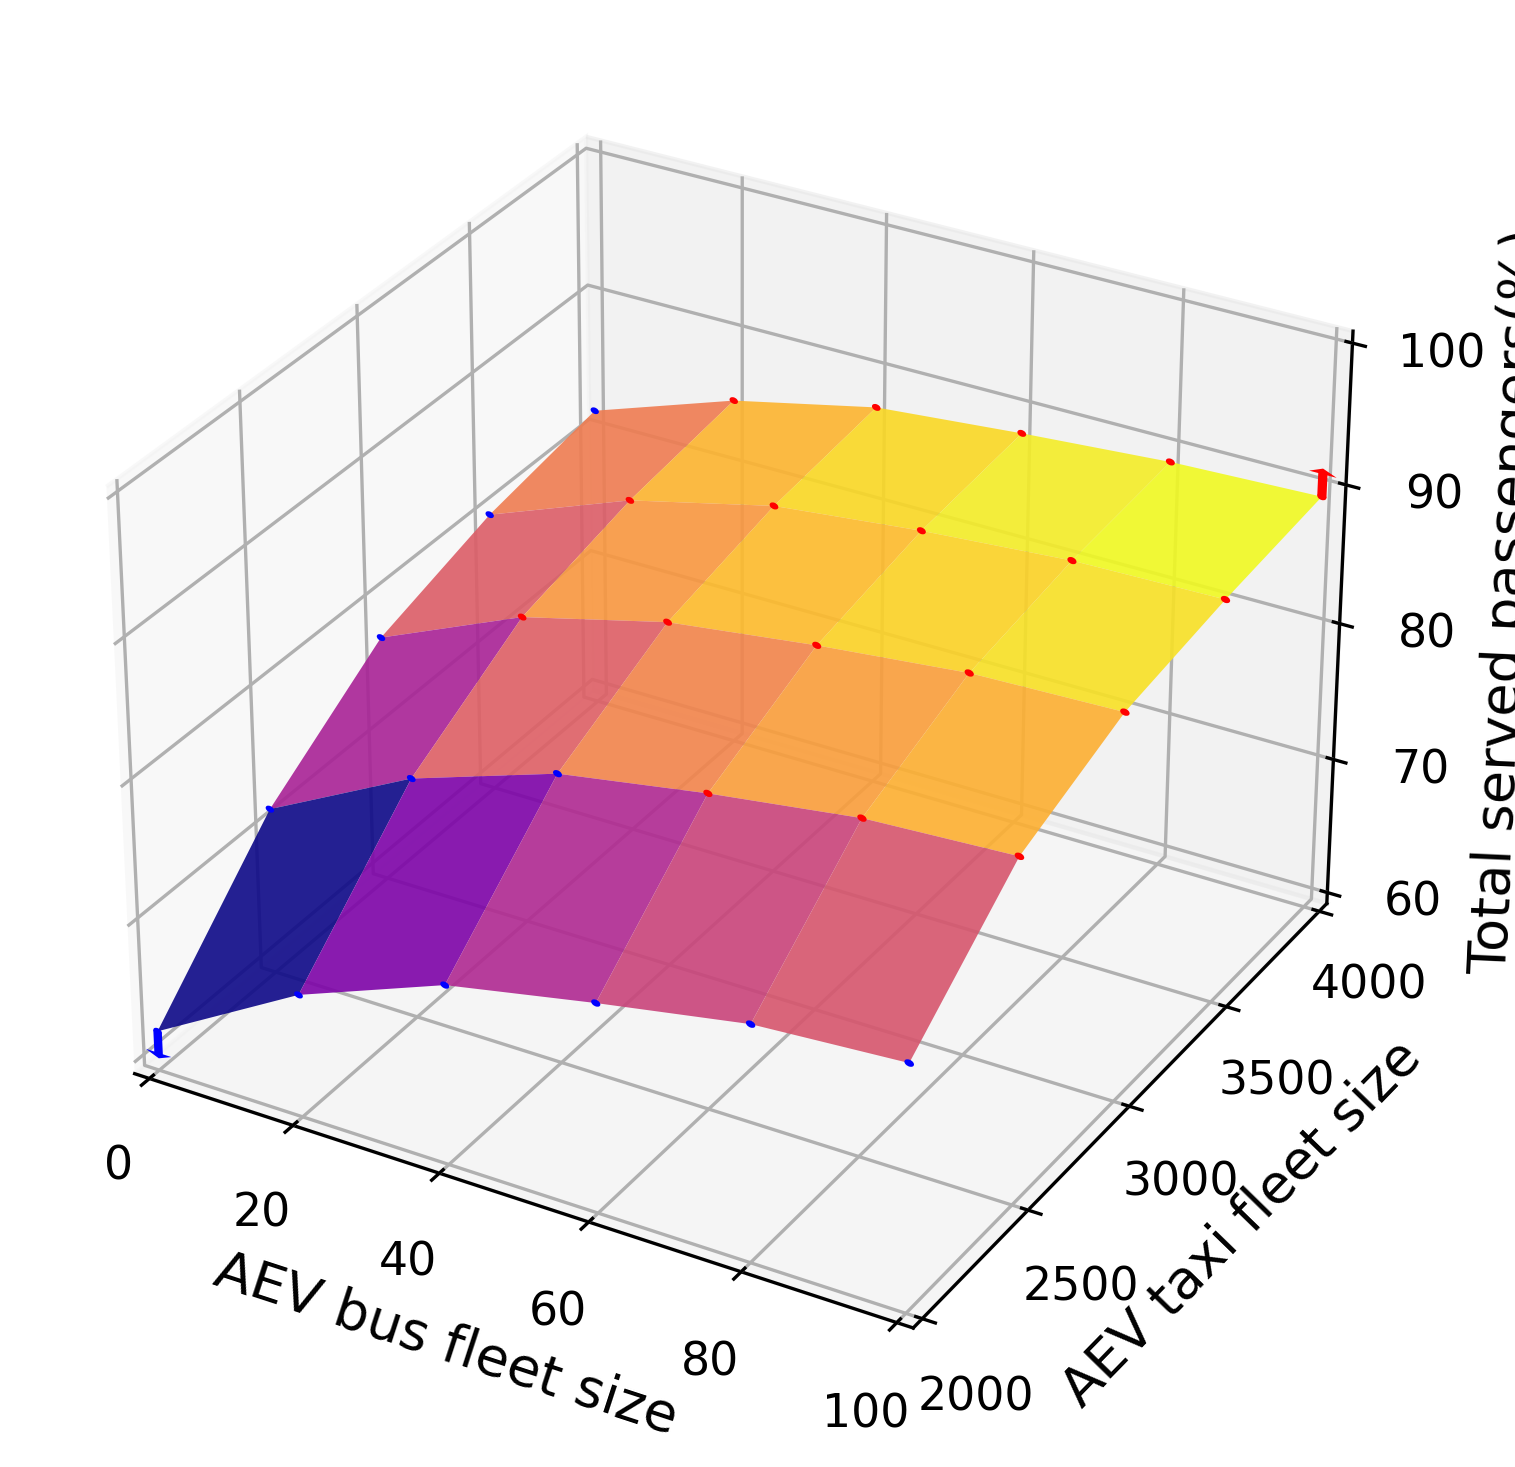

In [47]:
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection='3d')

agg_served_pass = np.mean(served_pass, axis = (0,1))
m,n = agg_served_pass.shape
ax.view_init(30, -60)

# create a m x n vertex mesh
xx, yy = np.meshgrid(np.linspace(1,n,n), np.linspace(1,m,m))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy
Z =  agg_served_pass

cset = ax.plot_surface(X, Y, Z, cmap=cm.plasma, zorder = 1, alpha=0.9)

# Z2 =  served_pass[1,:,:]

# cset = ax.plot_surface(X, Y, Z2, cmap=cm.viridis, zorder = 1, alpha=0.5)

ax.set_xticks(np.arange(1,n+1,1), np.arange(0,n,1)*20)
ax.set_yticks(np.arange(1,m+1,1), np.arange(0+4,m+4,1)*500)
ax.set_zticks(np.arange(0,1.01,0.1), np.arange(0,101,10))
ax.tick_params(axis='z', pad=5)

ax.set_zlim((0.6,1))
ax.set_xlim((1,n))
ax.set_ylim((1,m))

# threshold
threshold = np.mean(Z)

Z_ind = Z>threshold

for i in range(n):
    for j in range(m):
        if Z_ind[j,i]:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'red', radius = 0.06)
        else:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'blue', radius = 0.06)

# max and min
for i in range(n):
    for j in range(m):
        if Z[j,i] == np.max(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', radius = 0.02)
        elif Z[j,i] == np.min(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', flag=False, radius = 0.02)


ax.set_xlabel('AEV bus fleet size')
ax.set_ylabel('AEV taxi fleet size')
ax.set_zlabel('Total served passengers(%)')

plt.savefig('fig/exp2/mat_served_pass_.pdf')
plt.savefig('fig/exp2/mat_served_pass_.png')

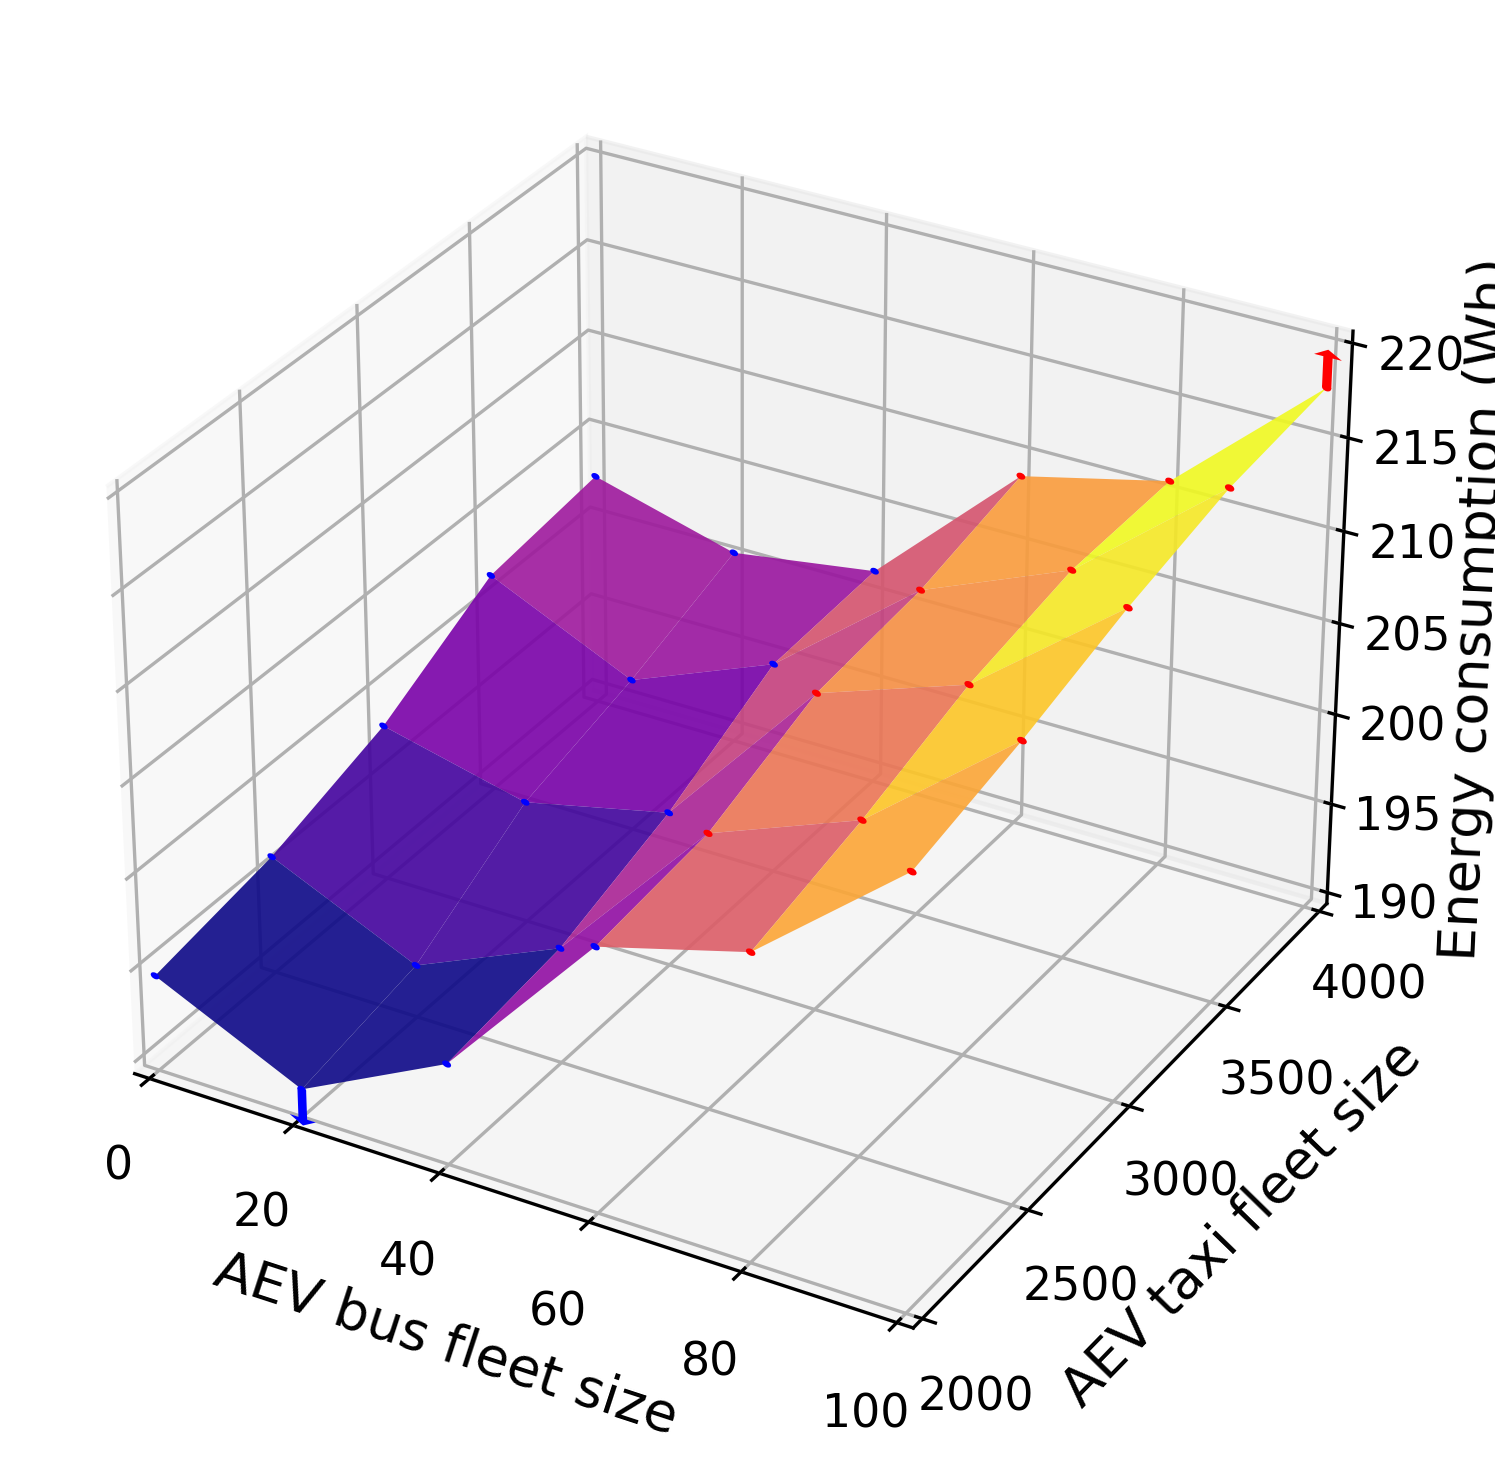

In [49]:
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection='3d')

agg_energy_consumption_pass = np.mean(energy_consumption_pass, axis = (0,1))
m,n = agg_energy_consumption_pass.shape
# ax.view_init(30, 120)

# create a 6 x 3 vertex mesh
xx, yy = np.meshgrid(np.linspace(1,n,n), np.linspace(1,m,m))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy
Z =  agg_energy_consumption_pass

cset = ax.plot_surface(X, Y, Z, cmap=cm.plasma, zorder = 1, alpha=0.9)

ax.set_xticks(np.arange(1,n+1,1), np.arange(0,n,1)*20)
ax.set_yticks(np.arange(1,m+1,1), np.arange(0+4,m+4,1)*500)
ax.set_zticks(np.arange(1.9,2.2,0.05), np.arange(190,221,5))
ax.tick_params(axis='z', pad=2)

ax.set_zlim((1.9,2.2))
ax.set_xlim((1,n))
ax.set_ylim((1,m))

# threshold
threshold = np.mean(Z)

Z_ind = Z>threshold

for i in range(n):
    for j in range(m):
        if Z_ind[j,i]:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'red', radius =  0.06)
        else:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'blue', radius =  0.06)

# max and min
for i in range(n):
    for j in range(m):
        if Z[j,i] == np.max(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', radius = 0.02)
        elif Z[j,i] == np.min(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', flag=False, radius = 0.02)


ax.set_xlabel('AEV bus fleet size')
ax.set_ylabel('AEV taxi fleet size')
ax.set_zlabel('Energy consumption (Wh) \nper served passenger')
# plt.tight_layout()

plt.savefig('fig/exp2/mat_energy_per_pass_.pdf')
plt.savefig('fig/exp2/mat_energy_per_pass_.png')

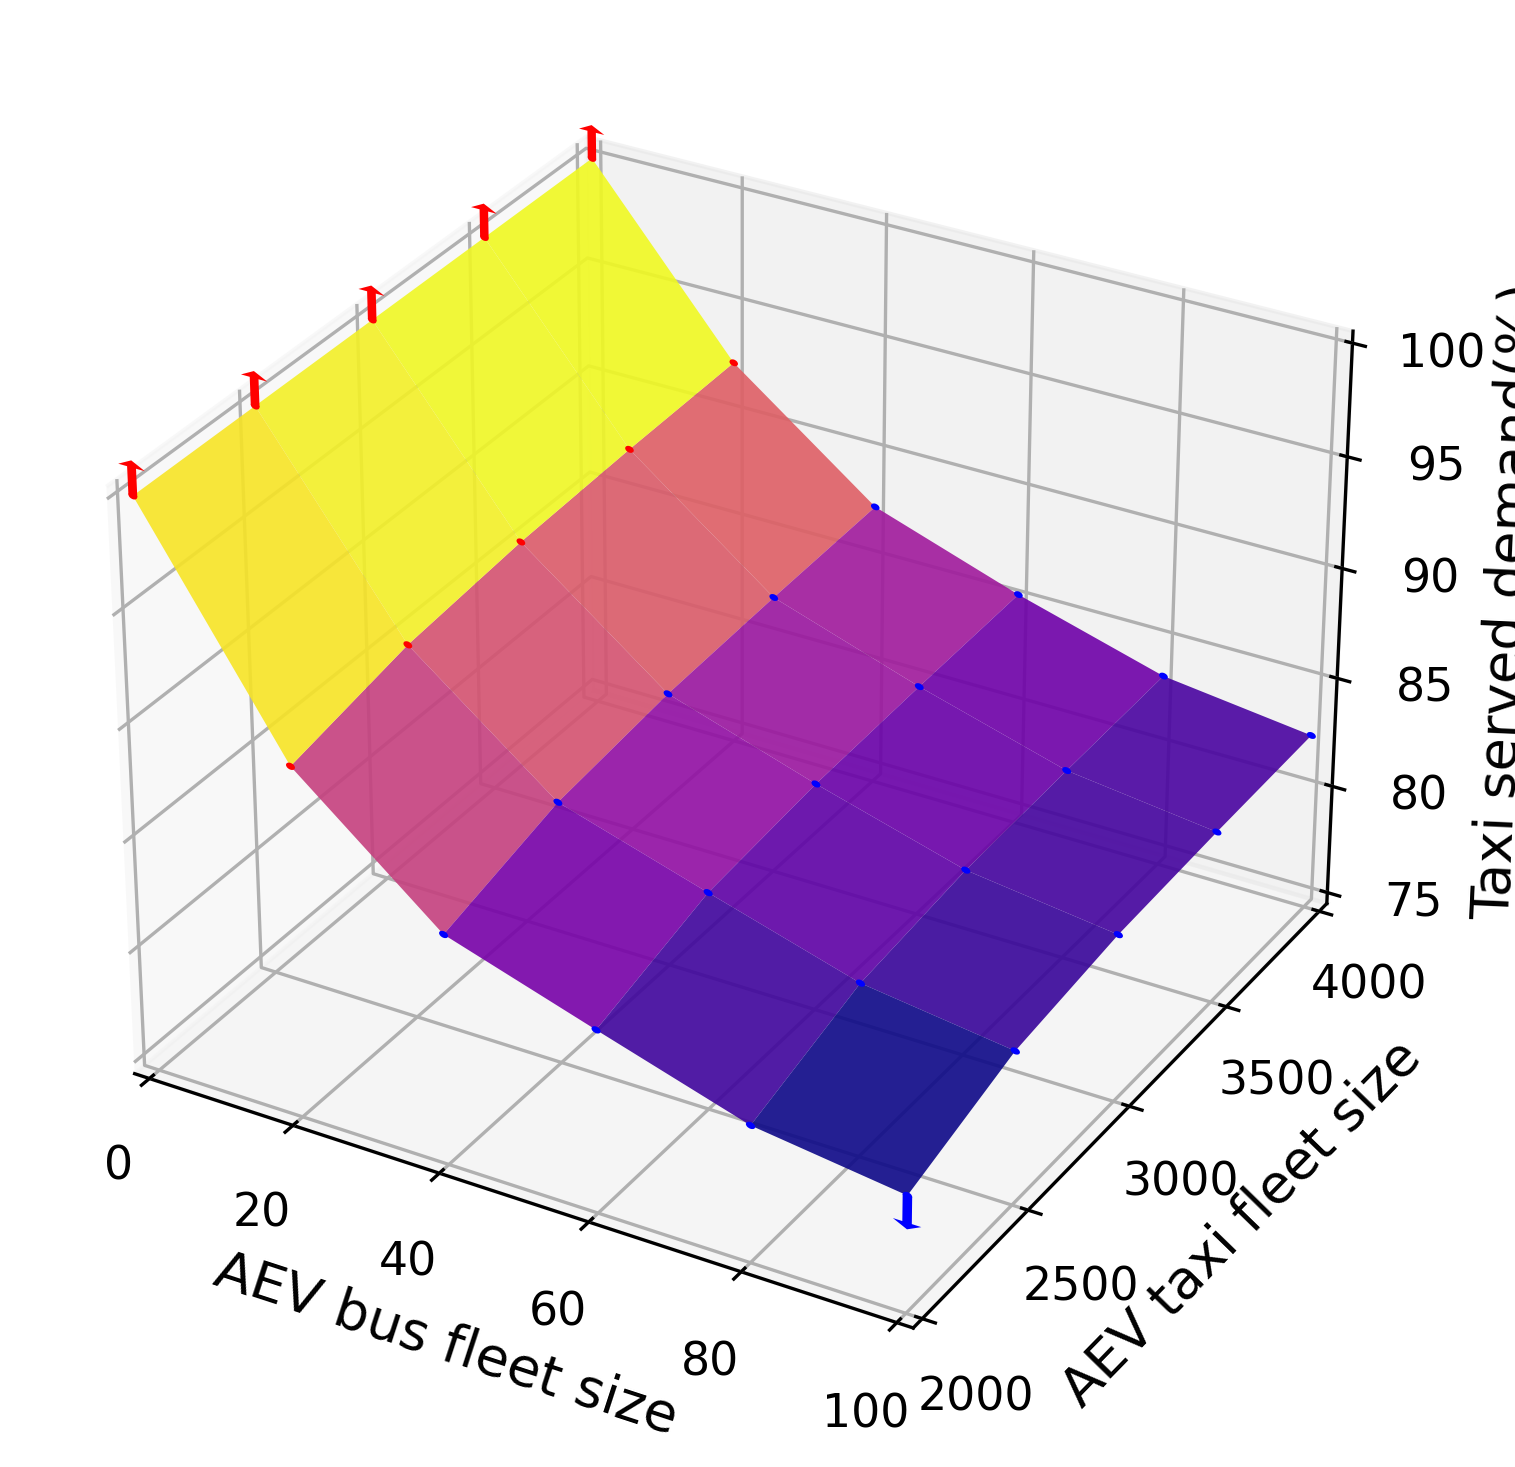

In [50]:
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection='3d')

agg_taxi_demand_share = np.mean(taxi_demand_share, axis = (0,1))
m,n = agg_taxi_demand_share.shape

ax.view_init(30, -60)

xx, yy = np.meshgrid(np.linspace(1,n,n), np.linspace(1,m,m))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy
Z =  agg_taxi_demand_share

cset = ax.plot_surface(X, Y, Z, cmap=cm.plasma, zorder = 1, alpha=.9)

ax.set_xticks(np.arange(1,n+1,1), np.arange(0,n,1)*20)
ax.set_yticks(np.arange(1,m+1,1), np.arange(0+4,m+4,1)*500)
ax.set_zticks(np.arange(0.75,1.01,0.05), np.arange(75,101,5))
ax.tick_params(axis='z', pad=5)

ax.set_zlim((0.75,1.0))
ax.set_xlim((1,n))
ax.set_ylim((1,m))


# threshold
threshold = np.mean(Z)

Z_ind = Z>threshold

for i in range(n):
    for j in range(m):
        if Z_ind[j,i]:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'red', radius =  0.06)
        else:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'blue', radius =  0.06)

for i in range(n):
    for j in range(m):
        if Z[j,i] == np.max(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', radius = 0.015)
        elif Z[j,i] == np.min(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', flag=False, radius = 0.015)

ax.set_xlabel('AEV bus fleet size')
ax.set_ylabel('AEV taxi fleet size')
ax.set_zlabel('Taxi served demand(%)')

plt.savefig('fig/exp2/mat_pass_split_ratio_.pdf')
plt.savefig('fig/exp2/mat_pass_split_ratio_.png')

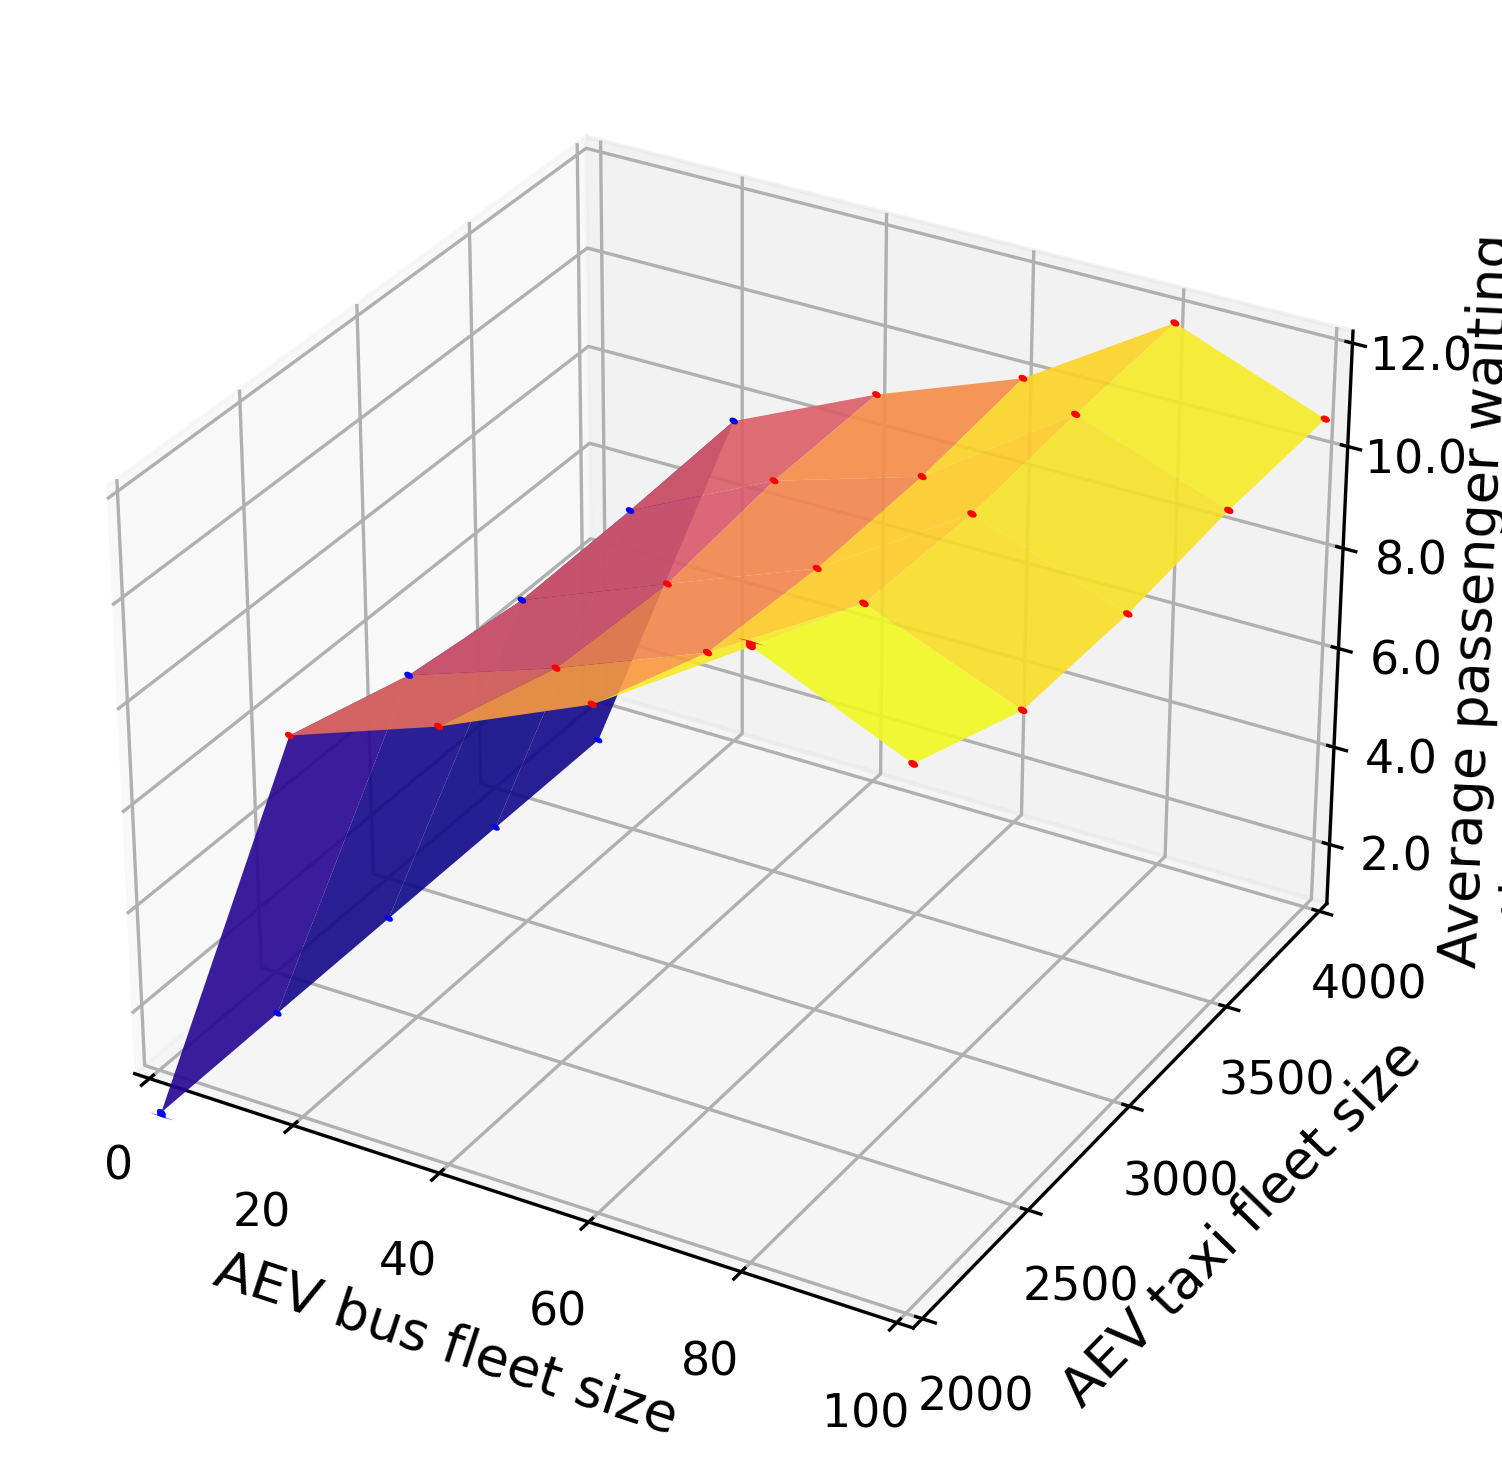

In [151]:
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection='3d')

ax.view_init(30, -60)

agg_avg_pass_waiting_time = np.mean(avg_pass_waiting_time, axis = (0,1))
m,n = agg_avg_pass_waiting_time.shape

# create a 6 x 3 vertex mesh
xx, yy = np.meshgrid(np.linspace(1,n,n), np.linspace(1,m,m))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy
Z =  agg_avg_pass_waiting_time * 60

cset = ax.plot_surface(X, Y, Z, cmap=cm.plasma, zorder = 1, alpha=.9)


ax.set_xticks(np.arange(1,n+1,1), np.arange(0,n,1)*20)
ax.set_yticks(np.arange(1,m+1,1), np.arange(0+4,m+4,1)*500)
ax.set_zticks(np.arange(0.0,12.01,2), np.arange(0,12.01,2))
ax.tick_params(axis='z', pad=2)

ax.set_zlim((1,12))
ax.set_xlim((1,n))
ax.set_ylim((1,m))

# threshold
threshold = np.mean(Z)

Z_ind = Z>threshold

for i in range(n):
    for j in range(m):
        if Z_ind[j,i]:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'red', radius = 0.06)
        else:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'blue', radius = 0.06)

# max and min
for i in range(n):
    for j in range(m):
        if Z[j,i] == np.max(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', radius = 0.1)
        elif Z[j,i] == np.min(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', flag=False, radius = 0.1)


ax.set_xlabel('AEV bus fleet size')
ax.set_ylabel('AEV taxi fleet size')
ax.set_zlabel('Average passenger waiting\n time (min) for AEV taxis')

plt.savefig('fig/exp2/mat_pass_waiting_time_.pdf')
plt.savefig('fig/exp2/mat_pass_waiting_time_.png')

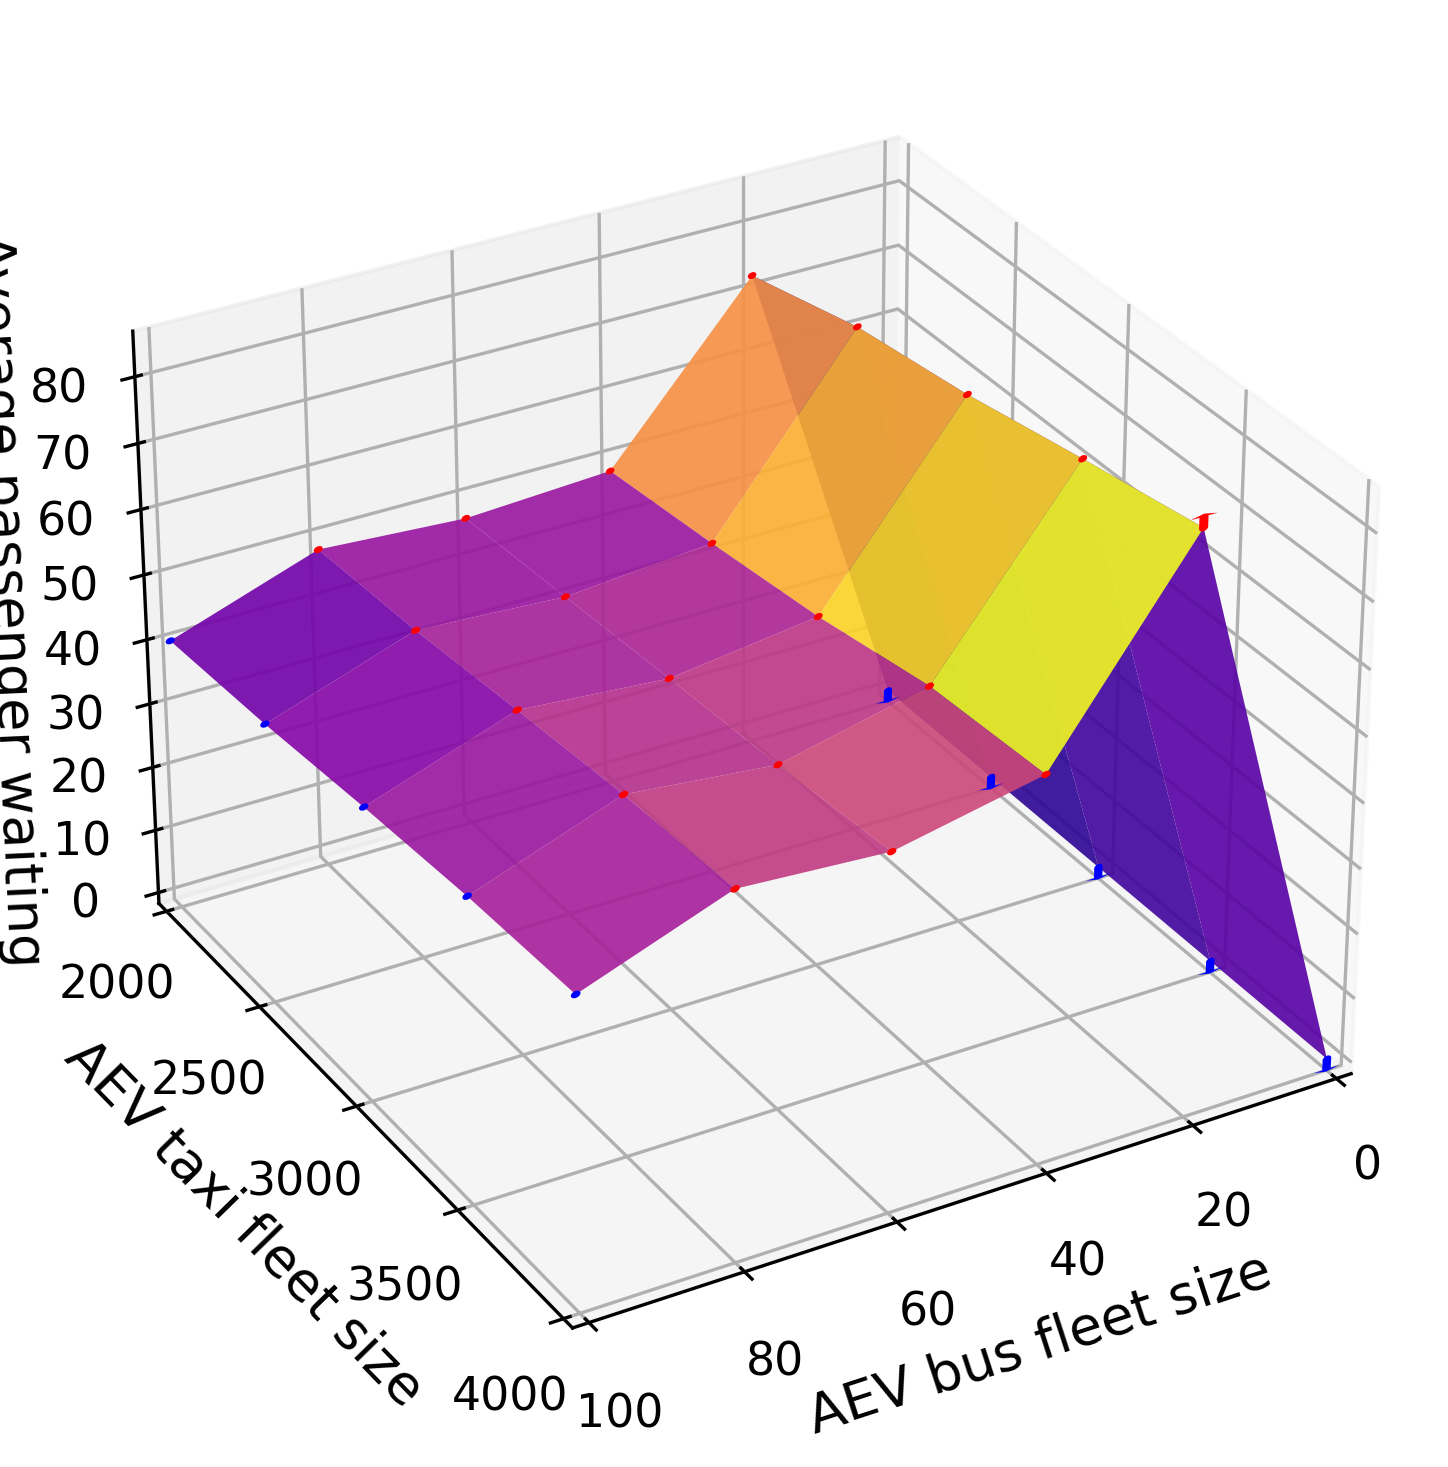

In [154]:
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection='3d')


ax.view_init(30, 60)

agg_avg_bus_waiting_time = np.mean(avg_bus_waiting_time, axis = (0,1))

m,n = agg_avg_bus_waiting_time.shape

# create a 6 x 3 vertex mesh
xx, yy = np.meshgrid(np.linspace(1,n,n), np.linspace(1,m,m))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy
Z =  agg_avg_bus_waiting_time * 60
Z = np.nan_to_num(Z)

cset = ax.plot_surface(X, Y, Z, cmap=cm.plasma, zorder = 1, alpha=.9)

ax.set_xticks(np.arange(1,n+1,1), np.arange(0,n,1)*20)
ax.set_yticks(np.arange(1,m+1,1), np.arange(0+4,m+4,1)*500)
ax.set_zticks(np.arange(0,86,10), np.arange(0,86,10))
ax.tick_params(axis='z', pad=3)

ax.set_zlim((0,85))
ax.set_xlim((1,n))
ax.set_ylim((1,m))

# threshold
threshold = np.mean(Z)

Z_ind = Z>threshold

for i in range(n):
    for j in range(m):
        if Z_ind[j,i]:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'red', radius = 0.06)
        else:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'blue', radius = 0.06)

for i in range(n):
    for j in range(m):
        if Z[j,i] == np.max(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', radius = 2)
        elif Z[j,i] == np.min(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', flag=False, radius = 2)


ax.set_xlabel('AEV bus fleet size')
ax.set_ylabel('AEV taxi fleet size')
ax.set_zlabel('Average passenger waiting\n time (min) for AEV buses')

plt.savefig('fig/exp2/mat_bus_waiting_time_.pdf')
plt.savefig('fig/exp2/mat_bus_waiting_time_.png')

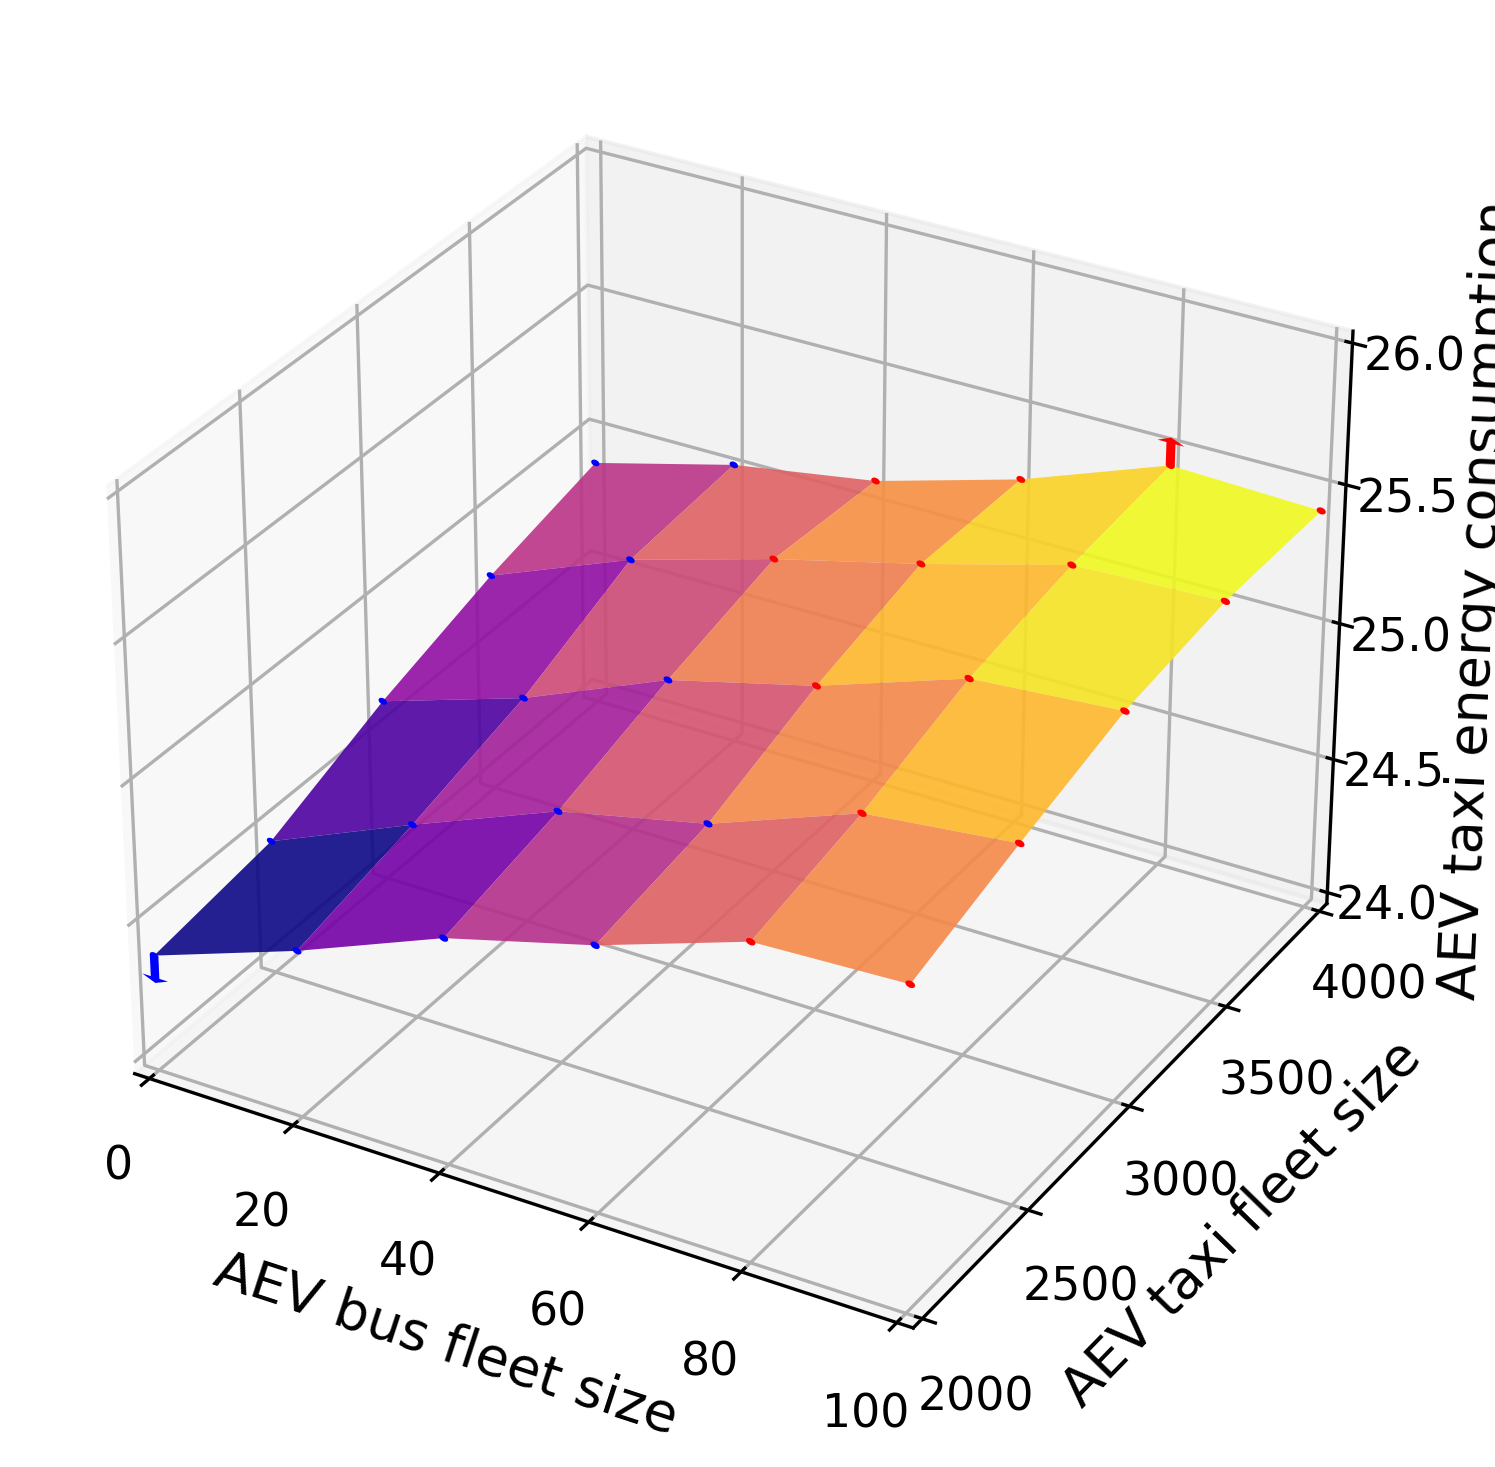

In [57]:
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection='3d')

ax.view_init(30, -60)
agg_energy_consumption = np.mean(energy_consumption, axis = (0,1))
m,n = agg_energy_consumption.shape

# create a 6 x 3 vertex mesh
xx, yy = np.meshgrid(np.linspace(1,n,n), np.linspace(1,m,m))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy
Z =  agg_energy_consumption
Z = np.nan_to_num(Z)

cset = ax.plot_surface(X, Y, Z, cmap=cm.plasma, zorder = 1, alpha=.9)

ax.set_xticks(np.arange(1,n+1,1), np.arange(0,n,1)*20)
ax.set_yticks(np.arange(1,m+1,1), np.arange(0+4,m+4,1)*500)
ax.set_zticks(np.arange(0.24,0.261,0.005), np.arange(24,26.1,0.5))
ax.tick_params(axis='z', pad=1)

ax.set_zlim((0.24,0.26))
ax.set_xlim((1,n))
ax.set_ylim((1,m))

# threshold
threshold = np.mean(Z)

Z_ind = Z>threshold

for i in range(n):
    for j in range(m):
        if Z_ind[j,i]:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'red', radius = 0.06)
        else:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'blue', radius = 0.06)

for i in range(n):
    for j in range(m):
        if Z[j,i] == np.max(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', radius = 0.001)
        elif Z[j,i] == np.min(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', flag=False, radius = 0.001)


ax.set_xlabel('AEV bus fleet size')
ax.set_ylabel('AEV taxi fleet size')
ax.set_zlabel('AEV taxi energy consumption\n (Wh) per occupied mile')

plt.savefig('fig/exp2/mat_taxi_energy_efficiency_.pdf')
plt.savefig('fig/exp2/mat_taxi_energy_efficiency_.png')

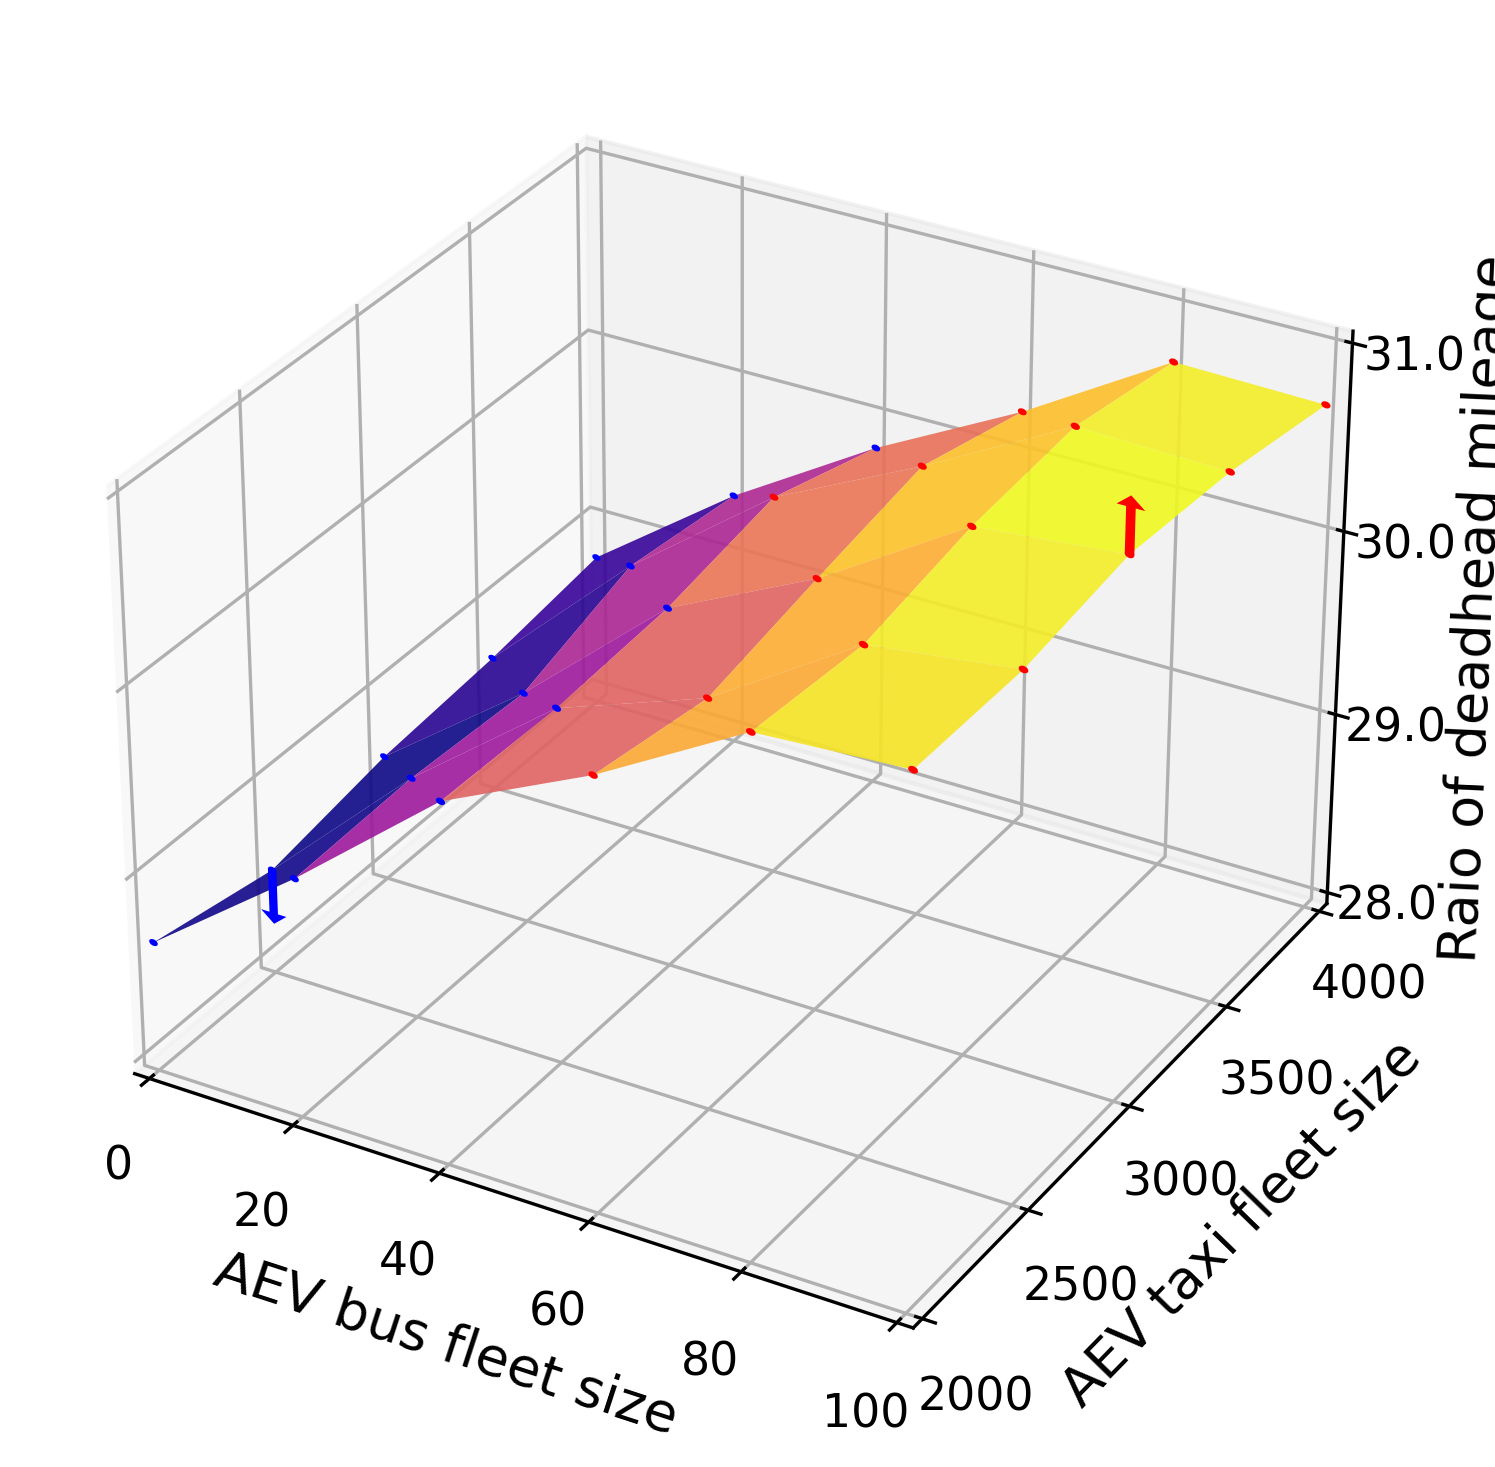

In [59]:
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection='3d')

ax.view_init(30, -60)

agg_daily_idle_time = np.mean(daily_idle_time, axis = (0,1))
m,n = agg_daily_idle_time.shape

# create a 6 x 3 vertex mesh
xx, yy = np.meshgrid(np.linspace(1,n,n), np.linspace(1,m,m))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx
Y =  yy
Z =  agg_daily_idle_time
Z = np.nan_to_num(Z)

cset = ax.plot_surface(X, Y, Z, cmap=cm.plasma, zorder = 1, alpha=.9)

ax.set_xticks(np.arange(1,n+1,1), np.arange(0,n,1)*20)
ax.set_yticks(np.arange(1,m+1,1), np.arange(0+4,m+4,1)*500)
ax.set_zticks(np.arange(0.28,0.311,0.01), np.arange(28,31.1,1))
ax.tick_params(axis='z', pad=1)

ax.set_zlim((0.28,0.31))
ax.set_xlim((1,n))
ax.set_ylim((1,m))

# threshold
threshold = np.mean(Z)

Z_ind = Z>threshold

for i in range(n):
    for j in range(m):
        if Z_ind[j,i]:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'red', radius = 0.06)
        else:
            add_point(ax, i+1, j+1, Z[j,i], fc = 'blue', radius = 0.06)

for i in range(n):
    for j in range(m):
        if Z[j,i] == np.max(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', radius = 0.003)
        elif Z[j,i] == np.min(Z):
            add_arrow(ax, i+1, j+1, Z[j,i], fc = 'red' if Z_ind[j,i] else 'blue', flag=False, radius = 0.003)


ax.set_xlabel('AEV bus fleet size')
ax.set_ylabel('AEV taxi fleet size')
ax.set_zlabel('Raio of deadhead mileage \nfor AEV taxis(%)')

plt.savefig('fig/exp2/mat_taxi_idle_time_.pdf')
plt.savefig('fig/exp2/mat_taxi_idle_time_.png')

+ The proper num of EV and E-bus.

+ Their relationship.

# Traffic impact

In [61]:
import geopandas as gpd
import pandas as pd

In [62]:
nyc_road = gpd.read_file("../map/road_fileNYC.shp")

c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


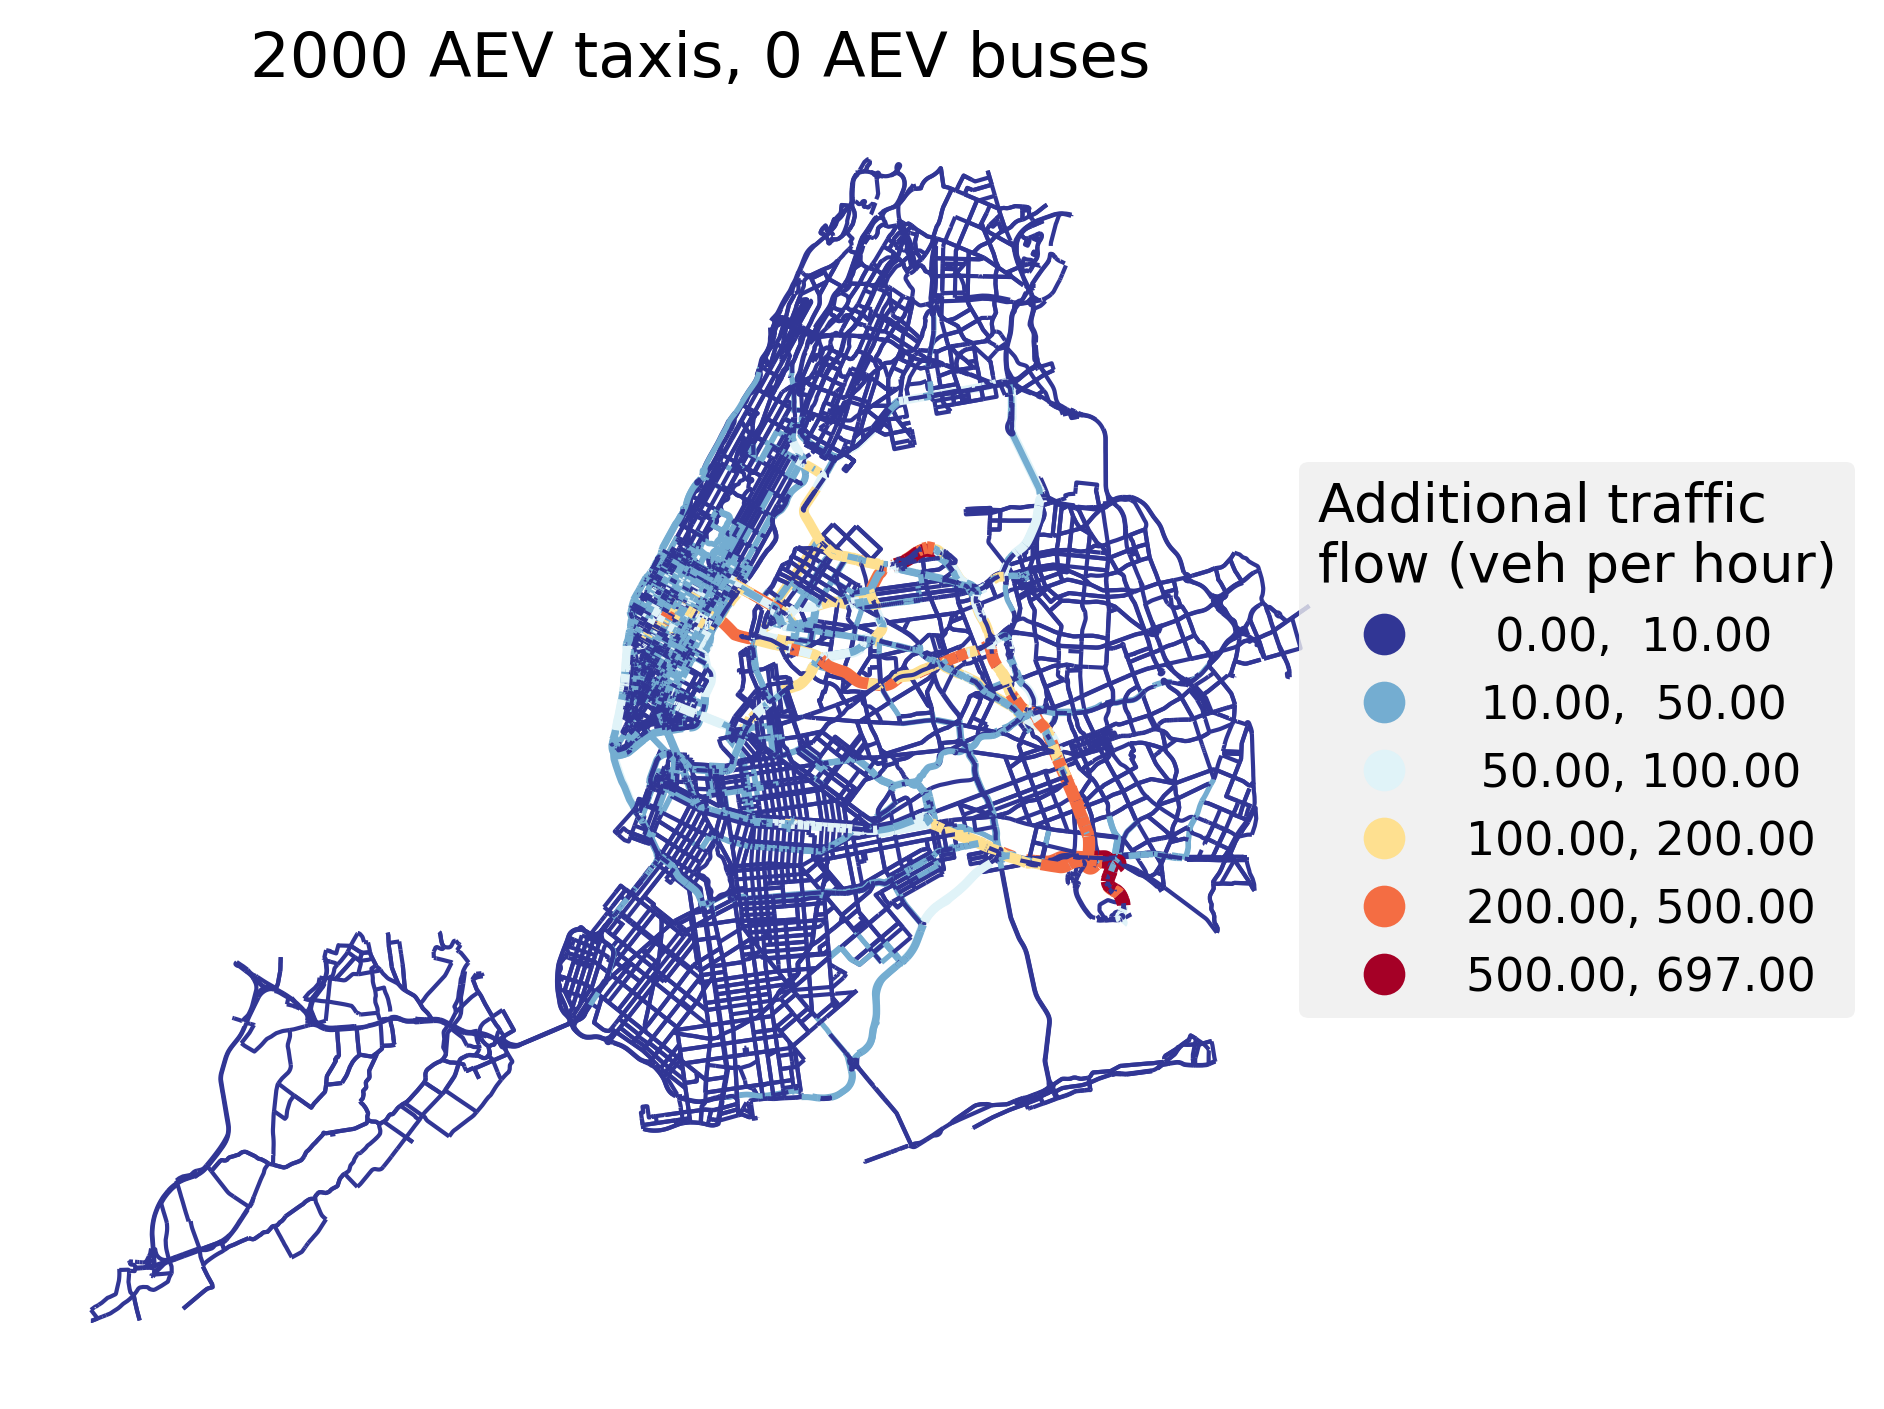

In [116]:
taxi_num = 2000
bus_num = 0
y1 = np.zeros(48)
y2 = np.zeros(48)
y3 = np.zeros(48)
y4 = np.zeros(48)
z = np.zeros(48)

df_link_list = []

for scenario in range(4):
    for case in [1,3,5,7,9]:
        if scenario == 3:
            case += 10
        curr_folder = "D:/OngoingResearch/2023_METSR_SIM/METS_R_Paper/data_analytics/exp2/scenario_2_case_1_seed_42_eco_false_bus_false_share_true_demand_100_taxi_"+str(taxi_num)+"_bus_"+str(bus_num)+"_pass/agg_output/"+str(taxi_num)+"_"+str(bus_num)+"/"
        filenames = os.listdir(curr_folder)
        for file in filenames:
            if "ZoneLog" in file:
                pass
                # df_zone = pd.read_csv(curr_folder+file)
            elif "NetworkLog" in file:
                df_network = pd.read_csv(curr_folder+file)
            elif "EVLog" in file:
                df_ev = pd.read_csv(curr_folder+file)
                df_ev = df_ev[df_ev['distance']>0]
            elif "BusLog" in file:
                pass
                # df_bus = pd.read_csv(curr_folder+file)
                # df_bus = df_bus[df_bus['routeID']!=-1]
            elif "LinkLog" in file:
                df_link  = pd.read_csv(curr_folder+file)
            elif "ChargerLog" in file:
                pass
                # df_charger = pd.read_csv(curr_folder+file)

#         # Spatio-temporal patterns
#         df_ev['timeIndex'] = df_ev['tick']//6000
#         df = df_ev[df_ev['tripType']==1].groupby(['timeIndex']).count()
#         df2 = df_ev[df_ev['tripType']==2].groupby(['timeIndex']).count()
#         df3 = df_ev[df_ev['tripType']==4].groupby(['timeIndex']).count()
#         df4 = df_ev.groupby(['timeIndex'])['cost'].sum()

#         df_network['timeIndex'] = df_network['tick']//6000
#         df_network =  df_network.groupby(['timeIndex'])['taxiLeavedPass'].max()
#         x1 = df.index[6:54]
#         y1 += df['tick'].values[6:54]
#         x2 = df2.index[6:54]
#         y2 +=  df2['tick'].values[6:54]
#         x3 = df3.index[6:54]
#         y3 += df3['tick'].values[6:54]
#         x4 = df_network.index[6:54]
#         y4 += df_network[6:54].values - df_network[5:53].values

        df_link_agg = df_link[df_link['tick']==27*12000]
        df_link_agg2 = df_link[df_link['tick']==3*12000]
        df_link_agg = pd.merge(left = df_link_agg, right = df_link_agg2, on='linkID', how='left')
        df_link_agg.fillna(0, inplace = True)
        df_link_agg['flow_x'] -= df_link_agg['flow_y'] 
        df_link_list.append(df_link_agg)

# y1/=20; y2/=20; y3/=20; y4/=20

# fig, ax = plt.subplots(figsize = (6,4))

# ax.bar(x1, y1, color = 'C1', label = 'Occupied')
# ax.bar(x2, y2, bottom = y1, color = 'C2', label = 'Repopsitioning')
# ax.bar(x3, y3, bottom = y1+y2, color = 'C9', label = 'Charging')

# ax2 = ax.twinx()
# # l1, = ax2.plot(df2.index[-48:], df4.values[-48:], '--', color = 'red', lw = 1, label = 'Energy consumption')

# l1, = ax2.plot(x4, y4, '--', color = 'red', lw = 1, label = 'Lost requests')

# handles, labels = ax.get_legend_handles_labels()

# ax.set_xlim([6,54])

# ax.set_ylabel('Number of fulfilled trips')
# ax2.set_ylabel('Number of left passengers')

# ax.set_xlabel('Hour of day')

# ax.set_xlim(6-0.5,6+48-0.5)

# ax.set_ylim([0,4500])
# ax2.set_ylim([0,4500])

# ax.legend(handles + [l1], labels+ ['Lost requests'], ncol=2, loc=2)

# ax.set_xticks(np.arange(0+6-0.5,6+48-0.5+1,4) , np.arange(0,25,2))

# ax.set_title("{} AEV taxis, {} AEV buses".format(taxi_num, bus_num))

# plt.tight_layout()

# plt.savefig('fig/exp2/ev_trips_{}_{}.pdf'.format(taxi_num, bus_num))
# plt.savefig('fig/exp2/ev_trips_{}_{}.png'.format(taxi_num, bus_num))

df_link_list = pd.concat(df_link_list)
df_link_agg = df_link_list.groupby('linkID')['flow_x'].sum().reset_index()
df_link_agg['flow_x']/=20

merged = pd.merge(nyc_road, df_link_agg, left_on ='linkID' ,right_on='linkID')
merged['flow_x'] //=24

ax = merged.plot('flow_x', scheme='UserDefined', lw=np.maximum(np.log(merged['flow_x']+1)/2,1), cmap='RdYlBu_r',legend=True,\
             legend_kwds={'loc': 'center left', 'bbox_to_anchor':(0.93,0.5),'title': 'Additional traffic \nflow (veh per hour)', 'edgecolor': 'none', 'facecolor': '#EEE'},\
                classification_kwds={'bins':np.array([10,50,100,200,500], dtype=int)})
plt.axis('off')
ax.set_title("{} AEV taxis, {} AEV buses".format(taxi_num, bus_num))
plt.tight_layout()
plt.savefig('fig/exp2/ev_spatio_{}_{}_.pdf'.format(taxi_num, bus_num))
plt.savefig('fig/exp2/ev_spatio_{}_{}_.png'.format(taxi_num, bus_num))

In [113]:
curr_folder = "exp2/scenario_2_case_1_seed_42_eco_false_bus_false_share_true_demand_100_taxi_4000_bus_100_pass/agg_output/4000_100/"
filenames = os.listdir(curr_folder)
print(filenames)
for file in filenames:
    if "ZoneLog" in file:
        df_zone = pd.read_csv(curr_folder+file)
    elif "NetworkLog" in file:
        df_network = pd.read_csv(curr_folder+file)
    elif "EVLog" in file:
        df_ev = pd.read_csv(curr_folder+file)
        df_ev = df_ev[df_ev['distance']>0]
    elif "BusLog" in file:
        df_bus = pd.read_csv(curr_folder+file)
        df_bus = df_bus[df_bus['routeID']!=-1]
    elif "LinkLog" in file:
        df_link  = pd.read_csv(curr_folder+file)
    elif "ChargerLog" in file:
        df_charger = pd.read_csv(curr_folder+file)

# Spatio-temporal patterns
df_ev['timeIndex'] = df_ev['tick']//6000
df_ev = df_ev[df_ev['timeIndex']<54]
df = df_ev[df_ev['tripType']==1].groupby(['timeIndex']).count()
df2 = df_ev[df_ev['tripType']==2].groupby(['timeIndex']).count()
df3 = df_ev[df_ev['tripType']==4].groupby(['timeIndex']).count()
df4 = df_ev.groupby(['timeIndex'])['cost'].sum()

df_network['timeIndex'] = df_network['tick']//6000
df_network = df_network[df_network['timeIndex']<54]
df_network =  df_network.groupby(['timeIndex'])['taxiLeavedPass'].max()

['BusLog-2023-01-05-01-14-42.csv', 'ChargerLog-2023-01-05-01-14-42.csv', 'EVLog-2023-01-05-01-14-42.csv', 'LinkLog-2023-01-05-01-14-42.csv', 'NetworkLog-2023-01-05-01-14-42.csv', 'TrajLog-2023-01-05-01-14-42.csv', 'ZoneLog-2023-01-05-01-14-42.csv']


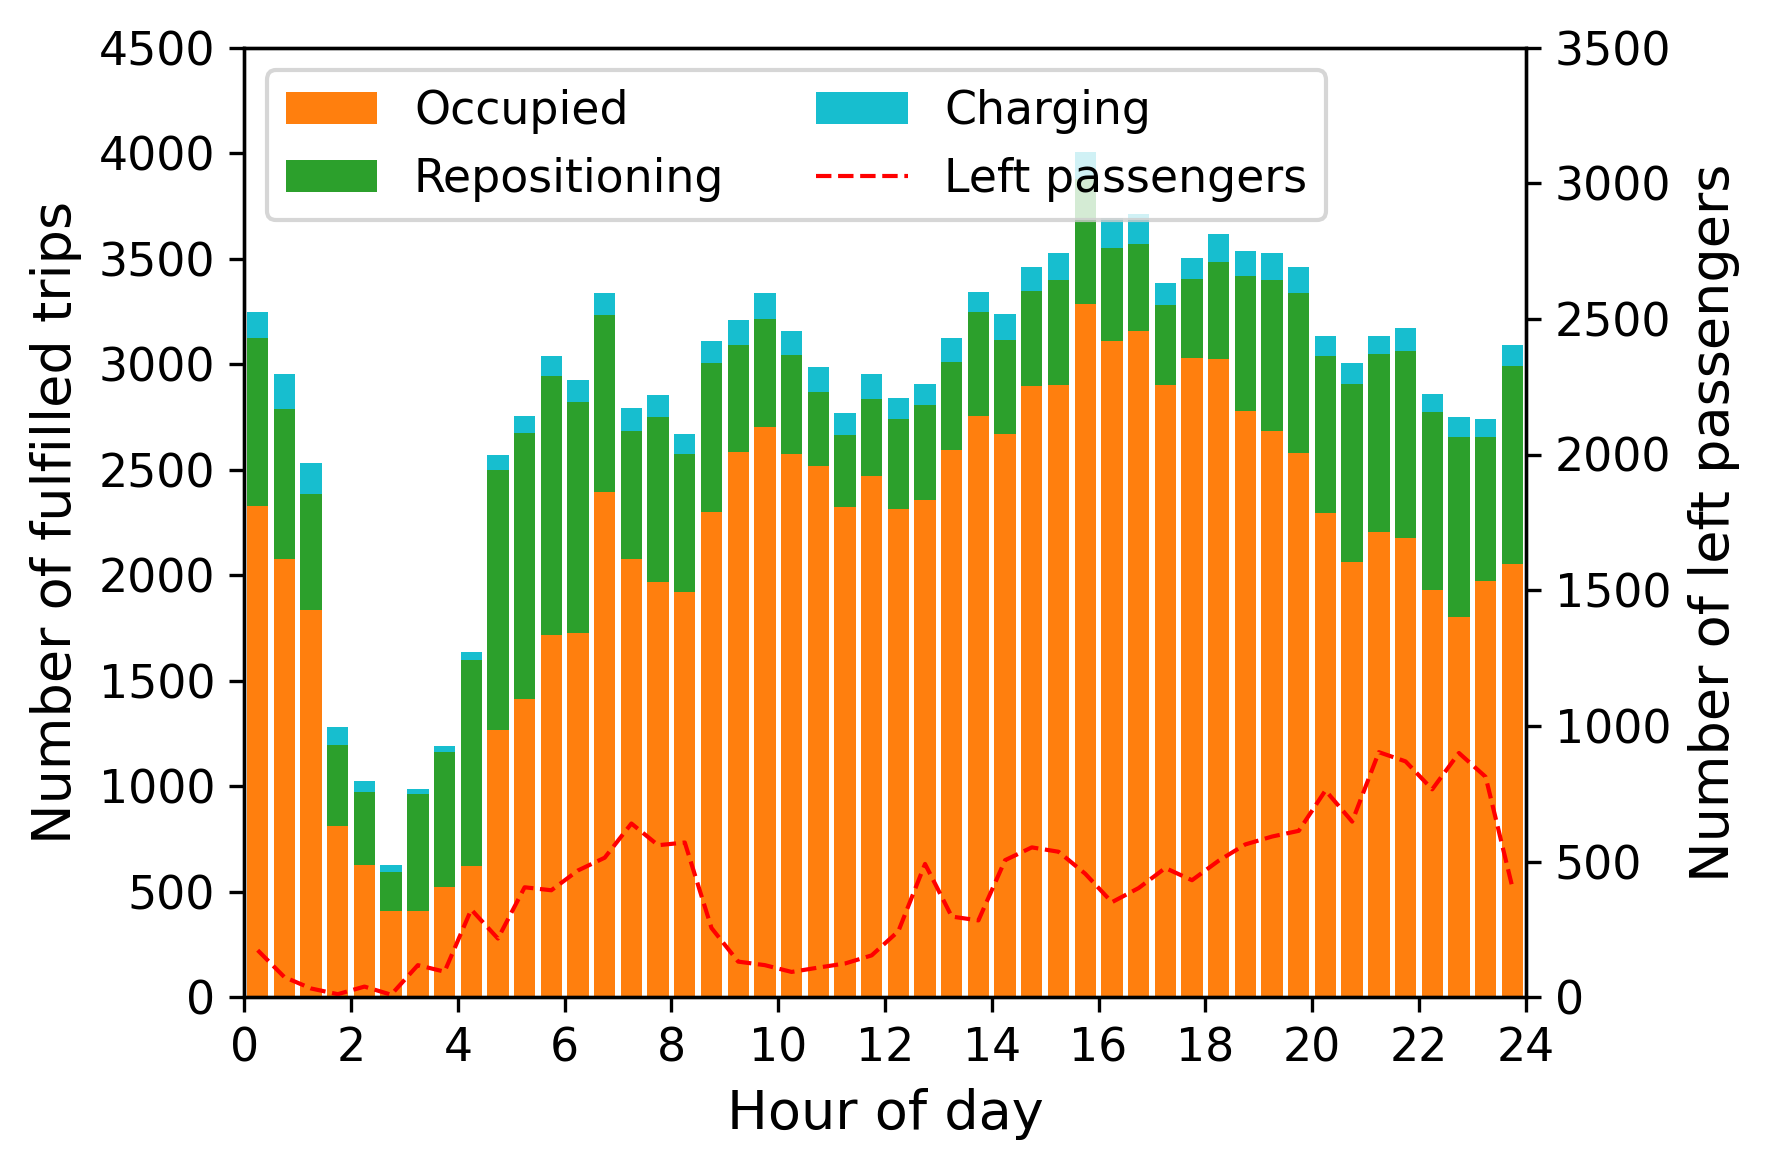

In [114]:
fig, ax = plt.subplots(figsize = (6,4))

ax.bar(df.index[-48:], df['tick'].values[-48:], color = 'C1', label = 'Occupied')
ax.bar(df2.index[-48:], df2['tick'].values[-48:], bottom = df['tick'].values[-48:], color = 'C2', label = 'Repositioning')
ax.bar(df2.index[-48:], df3['tick'].values[-48:], bottom = df['tick'].values[-48:]+df2['tick'].values[-48:], color = 'C9', label = 'Charging')

ax2 = ax.twinx()
# l1, = ax2.plot(df2.index[-48:], df4.values[-48:], '--', color = 'red', lw = 1, label = 'Energy consumption')

l1, = ax2.plot(df_network.index[-48:], df_network[-48:].values - df_network[-49:-1].values, '--', color = 'red', lw = 1, label = 'Left passengers')

handles, labels = ax.get_legend_handles_labels()

ax.set_ylabel('Number of fulfilled trips')
ax2.set_ylabel('Number of left passengers')

ax.set_xlabel('Hour of day')

ax.set_xlim(6-0.5,6+48-0.5)

ax.set_ylim([0,4500])
ax2.set_ylim([0,3500])

ax.legend(handles + [l1], labels+ ['Left passengers'], ncol=2, loc=2)

ax.set_xticks(np.arange(6+0-0.5,6+48-0.5+1,4) , np.arange(0, 25, 2))

plt.tight_layout()

plt.savefig('fig/exp2/ev_trips_4000_100_.pdf')
plt.savefig('fig/exp2/ev_trips_4000_100_.png')